In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from reddening_laws import *
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
dist_df = pd.read_csv('final_data_files/dist_spect_m4_clipped.csv')
# fill in with zeros to conform to fit_reddening input requirements
fill_values = pd.DataFrame(np.zeros([4,7]), columns=dist_df.columns.values)
# show columns for reference
print dist_df.columns.values

['wavelength' 'dist_ab' 'err_ab' 'dist_c' 'err_c' 'dist_mean' 'err_mean']


In [3]:
def do_the_fit(dist_df, startype):
    dist_df['dist_plus2'] = dist_df['dist_' + startype] + 2*dist_df['err_' + startype]
    dist_df['dist_minus2'] = dist_df['dist_' + startype] - 2*dist_df['err_' + startype]
    dist_full_df = pd.concat([fill_values, dist_df])
    reddening_input = pd.concat([dist_full_df['dist_' + startype], dist_full_df['err_' + startype]], axis=0)
    dist, Av, dist_err, Av_err, Alam = fit_reddening(*reddening_input)
    reddening_input2 = pd.concat([dist_full_df.dist_plus2, dist_full_df['err_' + startype]], axis=0)
    dist2, Av2, dist_err2, Av_err2, Alam = fit_reddening(*reddening_input2)
    reddening_input3 = pd.concat([dist_full_df.dist_minus2, dist_full_df['err_' + startype]], axis=0)
    dist3, Av3, dist_err3, Av_err3, Alam = fit_reddening(*reddening_input3)
    return dist_df, dist, dist_err, Av, Av_err, Av2, Av3, Alam

In [4]:
startype = 'ab'
if startype=='mean':
    alpha=1.
else:
    alpha=0.3
dist_df, dist, dist_err, Av, Av_err, Av2, Av3, Alam = do_the_fit(dist_df, startype)

In [5]:
# make extinction curve
nearir_x = np.linspace(1.22,1.5,50)
midir_x = np.linspace(1.5,4.5,100)

Rv = 3.1
Ak = ccm_nearir(2.164,Rv)

nearir_y = ccm_nearir(nearir_x,Rv) * Av + dist
midir_y = indebetouw_ir(midir_x) * Ak * Av + dist

nearir_y_2 = ccm_nearir(nearir_x,Rv) * Av2 + dist
midir_y_2 = indebetouw_ir(midir_x) * Ak * Av2 + dist

nearir_y_3 = ccm_nearir(nearir_x,Rv) * Av3 + dist
midir_y_3 = indebetouw_ir(midir_x) * Ak * Av3 + dist

/Users/Meredith/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


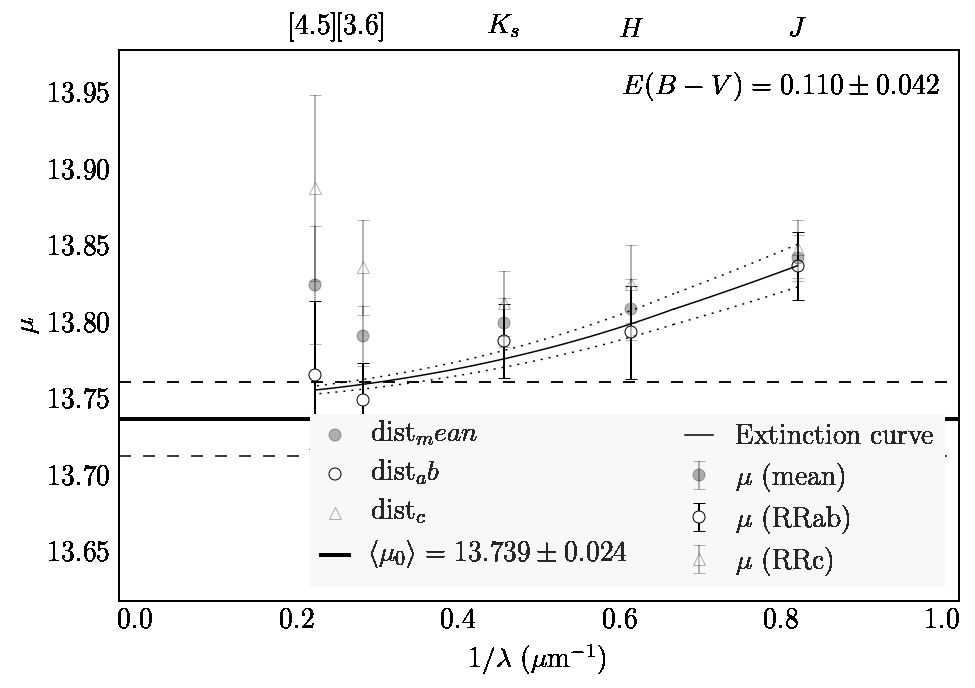

In [6]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
# add shadow axis object for wavelength labels
ax2 = ax.twiny()
# make line for distance modulus
x = np.linspace(-0.05,1.95,2)
y = x * 0 + dist
# plot the things - CURRENTLY FUCKED UP
# FUCKING MATPLOTLIB WHAT THE FUCK
ax.errorbar(1/dist_df.wavelength, dist_df.dist_mean, yerr=dist_df.err_mean, 
            color='k', mfc='k', fmt='o', label='$\mu$ (mean)', zorder=10, alpha=alpha)
ax.errorbar(1/dist_df.wavelength, dist_df.dist_ab, yerr=dist_df.err_ab,
            color='k', mfc='w', fmt='o', label='$\mu$ (RRab)', zorder=0)
ax.errorbar(1/dist_df.wavelength, dist_df.dist_c, yerr=dist_df.err_c,
            color='k', mfc='w', fmt='^', label='$\mu$ (RRc)', zorder=0, alpha=alpha)
ppl.plot(ax, x, y, 'k-', lw=2, label=r'$\langle\mu_0\rangle = {:.3f}\pm{:.3f}$'.format(dist,dist_err))
ppl.plot(ax, x, y + dist_err, 'k--')
ppl.plot(ax, x, y - dist_err, 'k--')
ppl.plot(ax, x, y + dist_err, 'k--')
ppl.plot(ax, 1/nearir_x, nearir_y, 'k-', label='Extinction curve')
ppl.plot(ax, 1/midir_x, midir_y, 'k-')
ppl.plot(ax, 1/nearir_x, nearir_y_2, 'k:')
ppl.plot(ax, 1/midir_x, midir_y_2, 'k:')
ppl.plot(ax, 1/nearir_x, nearir_y_3, 'k:')
ppl.plot(ax, 1/midir_x, midir_y_3, 'k:')
ax.set_xlim(-0.02,1.02)
ppl.legend(ax, loc=4, prop={'size':14}, numpoints=1, handlelength=1, ncol=2)
ax2.set_xlim(ax.get_xlim())
ax2.xaxis.set_ticks_position('none')
# set top tick labels to bandpasses
ax2.set_xticks(1/dist_df.wavelength)
ax2.set_xticklabels(['$J$', '$H$',  '$K_s$', '[3.6]', '[4.5]'])
ax.set_ylim(13.62,13.98)
ax.text(ax.get_xlim()[1]-0.025,ax.get_ylim()[1]-0.015,
        '$E(B-V) = {:.3f} \pm {:.3f}$'.format(Av/3.1,Av_err/3.1), ha='right',va='top')
ax.set_xlabel(r'$1/\lambda\ (\mu\mathrm{m}^{-1})$')
ax.set_ylabel(r'$\mu$')
fig.tight_layout()
#fig.savefig('final_plots/multiwavelength_distance_m4_clipped_{}.pdf'.format(startype), dpi=300)

In [7]:
u0_mean = dist_df.dist_mean.values - (Alam * Av)
u0err_mean = np.sqrt(dist_df.err_mean.values**2 + (Alam * Av_err)**2)
u0_ab = dist_df.dist_ab.values - (Alam * Av)
u0err_ab = np.sqrt(dist_df.err_ab.values**2 + (Alam * Av_err)**2)
u0_c = dist_df.dist_c.values - (Alam * Av)
u0err_c = np.sqrt(dist_df.err_c.values**2 + (Alam * Av_err)**2)

u0 = np.array([u0_ab, u0err_ab, u0_c, u0err_c, u0_mean, u0err_mean]).T

In [8]:
for i in u0:
    print r'& ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ \\'.\
    format(i[0], i[1], i[2], i[3], i[4], i[5])

& $13.739 \pm 0.044$ & $13.750 \pm 0.043$ & $13.744 \pm 0.041$ \\
& $13.733 \pm 0.039$ & $13.764 \pm 0.035$ & $13.748 \pm 0.031$ \\
& $13.751 \pm 0.028$ & $13.775 \pm 0.026$ & $13.763 \pm 0.022$ \\
& $13.729 \pm 0.026$ & $13.815 \pm 0.032$ & $13.770 \pm 0.021$ \\
& $13.749 \pm 0.049$ & $13.871 \pm 0.061$ & $13.807 \pm 0.039$ \\
